# Wellco churn prediction

## Imports

In [1]:
import pandas as pd
import numpy as np
from google.colab import drive

# Group sites together
import matplotlib.pyplot as plt
import seaborn as sns

# prep data
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# AE
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers

from sklearn.metrics import classification_report, roc_auc_score


## EDA and preprocessing

### App usage

In [5]:
drive.mount('/content/drive')
path = "/content/drive/MyDrive/cv and more/home_tasks_25/vi/data/app_usage.csv"
app_usage = pd.read_csv(path, encoding='latin-1')
print("Shape: ",app_usage.shape)
# Preview data
print("Number of nulls: ", app_usage.isna().sum().sum())
print("Number of duplicates: ", app_usage.duplicated().sum())
app_usage['timestamp'] = pd.to_datetime(app_usage['timestamp'])
app_usage['date'] = app_usage['timestamp'].dt.date # Convert to date and then format
print("App Usage Min Date:", app_usage['date'].min())
print("App Usage Max Date:", app_usage['date'].max())
app_usage.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Shape:  (97789, 3)
Number of nulls:  0
Number of duplicates:  0
App Usage Min Date: 2025-07-01
App Usage Max Date: 2025-07-14


,member_id,event_type,timestamp,date
0,1,session,2025-07-13 08:43:37,2025-07-13
1,1,session,2025-07-14 15:28:58,2025-07-14
2,1,session,2025-07-02 19:43:17,2025-07-02
3,1,session,2025-07-09 09:40:14,2025-07-09
4,1,session,2025-07-07 00:39:54,2025-07-07


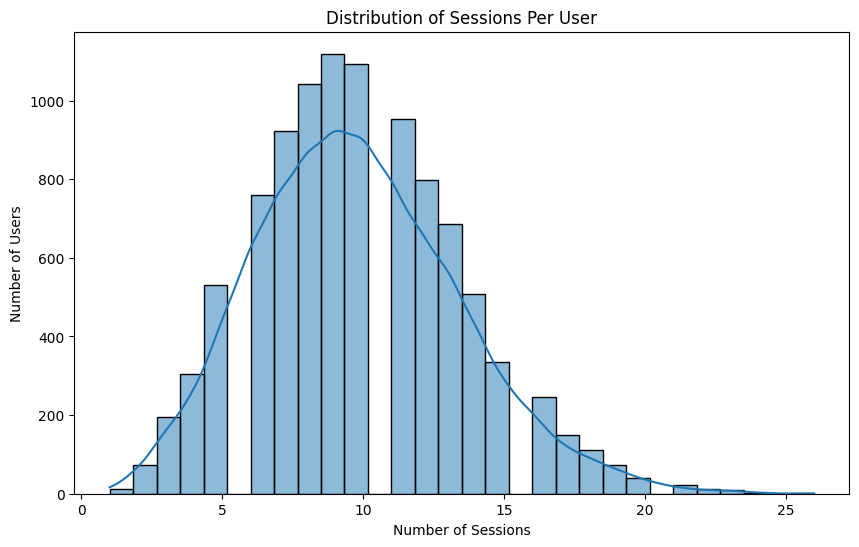

In [55]:
sessions_per_user = app_usage.groupby('member_id').size().reset_index(name='session_count')

plt.figure(figsize=(10, 6))
sns.histplot(data=sessions_per_user, x='session_count', bins=30, kde=True)
plt.title('Distribution of Sessions Per User')
plt.xlabel('Number of Sessions')
plt.ylabel('Number of Users')
plt.show()

### Diagnosis

In [24]:
path_claims = "/content/drive/MyDrive/cv and more/home_tasks_25/vi/data/claims.csv"
claims = pd.read_csv(path_claims, encoding='latin-1')
print("Shape: ",claims.shape)
# Preview data
print("Number of nulls: ", claims.isna().sum().sum())
print("Number of duplicates: ", claims.duplicated().sum())
print("Min date:", claims['diagnosis_date'].min())
print("Max date:", claims['diagnosis_date'].max())
display(claims.head())


Shape:  (64576, 3)
Number of nulls:  0
Number of duplicates:  1676
Min date: 2025-07-01
Max date: 2025-07-14


,member_id,icd_code,diagnosis_date
0,1,Z71.3,2025-07-09
1,1,Z71.3,2025-07-14
2,1,J00,2025-07-12
3,1,M54.5,2025-07-01
4,1,I10,2025-07-12


In [46]:
claims['icd_code'].value_counts()

,count
icd_code,
Z71.3,9145
I10,9006
E11.9,8961
H10.9,5414
B34.9,5410
A09,5387
M54.5,5385
J00,5346
R51,5277


### Web Visits

In [58]:
path_web_visits = "/content/drive/MyDrive/cv and more/home_tasks_25/vi/data/web_visits.csv"
web_visits = pd.read_csv(path_web_visits, encoding='latin-1')
print("Shape: ",web_visits.shape)
# Preview data
print("Number of nulls: ", web_visits.isna().sum().sum())
print("Number of duplicates: ", web_visits.duplicated().sum())
web_visits['timestamp'] = pd.to_datetime(web_visits['timestamp'])
web_visits['date'] = web_visits['timestamp'].dt.date # Convert to date and then format
print("Web Visits Min Date:", web_visits['timestamp'].min())
print("Web Visits Max Date:", web_visits['timestamp'].max())
display(web_visits.head())

Shape:  (259340, 5)
Number of nulls:  0
Number of duplicates:  0
Web Visits Min Date: 2025-07-01 00:00:01
Web Visits Max Date: 2025-07-14 23:59:49


,member_id,url,title,description,timestamp,date
0,1,https://health.wellco/chronic/859,Diabetes management,Blood sugar and glycemic control,2025-07-02 22:38:22,2025-07-02
1,1,https://portal.site/tech/328,Gadget roundup,Smartphones and laptops news,2025-07-02 11:30:47,2025-07-02
2,1,https://health.wellco/heart/792,Hypertension basics,Blood pressure and lifestyle changes,2025-07-14 00:38:39,2025-07-14
3,2,https://example.com/gaming/674,Game reviews,Strategy tips and updates,2025-07-07 02:56:06,2025-07-07
4,2,https://living.better/stress/325,Stress reduction,Mindfulness and wellness,2025-07-02 15:53:38,2025-07-02


In [62]:
web_visits['title'].value_counts()

,count
title,
Top destinations,22600
Gadget roundup,22553
Electric vehicles,22395
New releases,22271
Match highlights,22257
Game reviews,21337
Dog training,14636
Budget planning,9791
High-fiber meals,5789


In [64]:
# Define keywords for each ICD-10 code
keywords = {
    'E11.9': ['diabetes', 'blood glucose', 'insulin resistance', 'glycemic control', 'HbA1c'],
    'I10': ['hypertension', 'blood pressure', 'heart health', 'cardiometabolic'],
    'Z71.3': ['dietary counseling', 'nutrition', 'lifestyle education', 'eating', 'food']
}

# Function to check for relevance to a specific ICD-10 code
def is_relevant(row, icd_code, keywords):
    text = (row['title'] + ' ' + row['description']).lower()
    for keyword in keywords[icd_code]:
        if keyword in text:
            return 1
    return 0

# Add columns for each ICD-10 code
for icd_code in keywords:
    web_visits[icd_code] = web_visits.apply(is_relevant, axis=1, icd_code=icd_code, keywords=keywords)

# Define health-related titles
health_titles = [
    'Aerobic exercise', 'Cardio workouts', 'Cardiometabolic health',
    'Cholesterol friendly foods', 'Diabetes management', 'Exercise routines',
    'HbA1c targets', 'Healthy eating guide', 'High-fiber meals',
    'Hypertension basics', 'Lowering blood pressure', 'Meditation guide',
    'Mediterranean diet', 'Restorative sleep tips', 'Sleep hygiene',
    'Strength training basics', 'Stress reduction', 'Weight management'
]

# Function to check for health-related content based on title
def is_health_related_by_title(row, health_titles):
    if row['title'] in health_titles:
        return 1
    return 0

# Add 'health_related' column using the new function
web_visits['health_related'] = web_visits.apply(is_health_related_by_title, axis=1, health_titles=health_titles)

# Add 'is_wellco' column
web_visits['is_wellco'] = web_visits['url'].str.contains("wellco").astype(int)

display(web_visits.head())

,member_id,url,title,description,timestamp,date,E11.9,I10,Z71.3,health_related,is_wellco
0,1,https://health.wellco/chronic/859,Diabetes management,Blood sugar and glycemic control,2025-07-02 22:38:22,2025-07-02,1,0,0,1,1
1,1,https://portal.site/tech/328,Gadget roundup,Smartphones and laptops news,2025-07-02 11:30:47,2025-07-02,0,0,0,0,0
2,1,https://health.wellco/heart/792,Hypertension basics,Blood pressure and lifestyle changes,2025-07-14 00:38:39,2025-07-14,0,1,0,1,1
3,2,https://example.com/gaming/674,Game reviews,Strategy tips and updates,2025-07-07 02:56:06,2025-07-07,0,0,0,0,0
4,2,https://living.better/stress/325,Stress reduction,Mindfulness and wellness,2025-07-02 15:53:38,2025-07-02,0,0,0,1,0


In [65]:
print(f"Ratio of health related: {web_visits['health_related'].mean():.2f}")
print(f"Ratio of diabetes: {web_visits['E11.9'].mean():.2f}")
print(f"Ratio of hypertension: {web_visits['I10'].mean():.2f}")
print(f"Ratio of dietary: {web_visits['Z71.3'].mean():.2f}")
print(f"Wellco search: {web_visits['is_wellco'].mean():.2f}")

Ratio of health related: 0.39
Ratio of diabetes: 0.07
Ratio of hypertension: 0.09
Ratio of dietary: 0.11
Wellco search: 0.10


### Churn

In [4]:
path_churn_labels = "/content/drive/MyDrive/cv and more/home_tasks_25/vi/data/churn_labels.csv"
churn_labels = pd.read_csv(path_churn_labels, encoding='latin-1')
print("Shape: ",churn_labels.shape)
# Preview data
print("Number of nulls: ", churn_labels.isna().sum().sum())
print("Number of duplicates: ", churn_labels.duplicated().sum())
print("Min date:", churn_labels['signup_date'].min())
print("Max date:", churn_labels['signup_date'].max())
display(churn_labels.head())

Shape:  (10000, 4)
Number of nulls:  0
Number of duplicates:  0
Min date: 2024-01-01
Max date: 2025-05-31


,member_id,signup_date,churn,outreach
0,1,2024-04-12,0,0
1,2,2025-03-11,0,0
2,3,2024-09-27,0,0
3,4,2024-04-16,1,0
4,5,2024-03-12,0,1


In [6]:
print(f"Ratio of churn: {churn_labels['churn'].mean():.2f}")
print(f"Ratio of outreach: {churn_labels['outreach'].mean():.2f}")

Ratio of churn: 0.20
Ratio of outreach: 0.40


In [7]:
last_session_date = app_usage.groupby('member_id')['timestamp'].max().reset_index(name='last_session_date')
last_session_date['last_session_date'] = pd.to_datetime(last_session_date['last_session_date']).dt.date
churn_labels = churn_labels.merge(last_session_date, on='member_id', how='left')
churn_labels['signup_date'] = pd.to_datetime(churn_labels['signup_date'])
churn_labels['last_session_date'] = pd.to_datetime(churn_labels['last_session_date'])
churn_labels['date_diff'] = (churn_labels['last_session_date'] - churn_labels['signup_date']).dt.days
display(churn_labels.head())

,member_id,signup_date,churn,outreach,last_session_date,date_diff
0,1,2024-04-12,0,0,2025-07-14,458.0
1,2,2025-03-11,0,0,2025-07-14,125.0
2,3,2024-09-27,0,0,2025-07-12,288.0
3,4,2024-04-16,1,0,2025-07-13,453.0
4,5,2024-03-12,0,1,2025-07-13,488.0


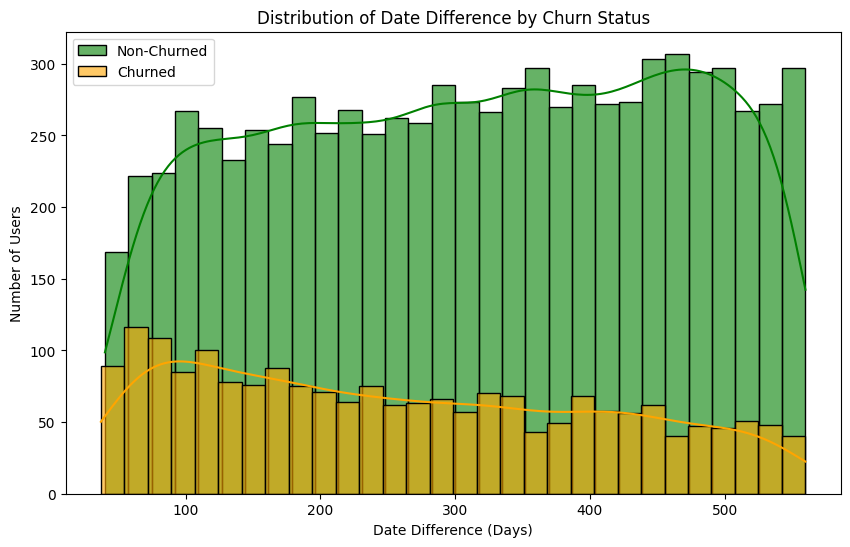

In [82]:
plt.figure(figsize=(10, 6))

# Histogram for non-churned users (churn = 0)
sns.histplot(data=churn_labels[churn_labels['churn'] == 0], x='date_diff', color='green', label='Non-Churned', kde=True, bins=30, alpha=0.6)

# Histogram for churned users (churn = 1)
sns.histplot(data=churn_labels[churn_labels['churn'] == 1], x='date_diff', color='orange', label='Churned', kde=True, bins=30, alpha=0.6)

plt.title('Distribution of Date Difference by Churn Status')
plt.xlabel('Date Difference (Days)')
plt.ylabel('Number of Users')
plt.legend()
plt.show()

### Preprocess

In [87]:
# Aggregate claims
claims['diagnosis_date'] = pd.to_datetime(claims['diagnosis_date']).dt.date

agg_claims = claims.copy()
agg_claims['Z713_diagnosis'] = agg_claims['icd_code'].apply(lambda x: 1 if x == 'Z71.3' else 0)
agg_claims['E119_diagnosis'] = agg_claims['icd_code'].apply(lambda x: 1 if x == 'E11.9' else 0)
agg_claims['i10_diagnosis'] = agg_claims['icd_code'].apply(lambda x: 1 if x == 'I10' else 0)
agg_claims['other_diagnosis'] = agg_claims['icd_code'].apply(lambda x: 1 if x not in ['Z71.3', 'E11.9', 'I10'] else 0)

agg_claims = agg_claims.groupby(['member_id', 'diagnosis_date']).max().reset_index()

agg_claims = agg_claims.rename(columns={'diagnosis_date': 'date'})

agg_claims = agg_claims[['member_id', 'date', 'Z713_diagnosis', 'E119_diagnosis', 'i10_diagnosis', 'other_diagnosis']]

In [89]:
# Aggeragate app usage
agg_app_usage = app_usage.groupby(['member_id', 'date']).size().reset_index(name='count_of_sessions')

In [93]:
# Create 'other_search' column (not related to E11.9, I10, or Z71.3)
web_visits['other_search'] = web_visits.apply(lambda row: 1 if row['E11.9'] == 0 and row['I10'] == 0 and row['Z71.3'] == 0 and row['health_related'] == 0 and row['is_wellco'] == 0 else 0, axis=1)

agg_web_searches = web_visits.groupby(['member_id', 'date']).agg(
    count_of_e119_search=('E11.9', 'sum'),
    count_of_i10_search=('I10', 'sum'),
    count_of_z713_search=('Z71.3', 'sum'),
    count_health_related_search=('health_related', 'sum'),
    count_wellco_search=('is_wellco', 'sum'),
    count_other_search=('other_search', 'sum')
).reset_index()

In [100]:
# Create a date range
start_date = pd.to_datetime('2025-07-01').date()
end_date = pd.to_datetime('2025-07-14').date()
all_dates = pd.date_range(start=start_date, end=end_date, freq='D').date

# Get unique member_ids from churn_labels
member_ids = churn_labels['member_id'].unique()

# Create a dataframe with all combinations of member_id and date
from itertools import product
state_table = pd.DataFrame(list(product(member_ids, all_dates)), columns=['member_id', 'date'])

# Merge with signup_date from churn_labels
state_table = pd.merge(state_table, churn_labels[['member_id', 'signup_date']], on='member_id', how='left')

# Convert date columns to datetime objects for calculation
state_table['date'] = pd.to_datetime(state_table['date'])
state_table['signup_date'] = pd.to_datetime(state_table['signup_date'])

# Calculate days since signup_date
state_table['days_since_signup_date'] = (state_table['date'] - state_table['signup_date']).dt.days

# Drop the signup_date column as it's no longer needed in the final state table
state_table = state_table.drop(columns=['signup_date'])

# Convert date columns in aggregated dataframes to datetime objects
agg_claims['date'] = pd.to_datetime(agg_claims['date'])
agg_app_usage['date'] = pd.to_datetime(agg_app_usage['date'])
agg_web_searches['date'] = pd.to_datetime(agg_web_searches['date'])

# Left join agg_claims
state_table = pd.merge(state_table, agg_claims, on=['member_id', 'date'], how='left')

# Left join agg_app_usage
state_table = pd.merge(state_table, agg_app_usage, on=['member_id', 'date'], how='left')

# Left join agg_web_searches
state_table = pd.merge(state_table, agg_web_searches, on=['member_id', 'date'], how='left')

# Fill NaN values with 0
state_table = state_table.fillna(0)

display(state_table.head())

,member_id,date,days_since_signup_date,Z713_diagnosis,E119_diagnosis,i10_diagnosis,other_diagnosis,count_of_sessions,count_of_e119_search,count_of_i10_search,count_of_z713_search,count_health_related_search,count_wellco_search,count_other_search
0,1,2025-07-01,445,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,2025-07-02,446,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0
2,1,2025-07-03,447,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,2025-07-04,448,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,2025-07-05,449,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
def check_interaction_search_health(row):
    if row['count_of_sessions'] > 0:
        member_id = row['member_id']
        session_date = row['date']
        # Define the time window: start from the beginning of the session date and end at the end of the next day
        start_time_window = pd.to_datetime(session_date)
        end_time_window = pd.to_datetime(session_date) + pd.Timedelta(days=1)


        # Filter web visits for the same member within the updated time window
        relevant_visits = web_visits[
            (web_visits['member_id'] == member_id) &
            (web_visits['timestamp'] >= start_time_window) &
            (web_visits['timestamp'] <= end_time_window) &
            (web_visits['health_related'] == 1)
        ]

        if not relevant_visits.empty:
            return 1
    return 0

def check_interaction_search_wellco(row):
    if row['count_of_sessions'] > 0:
        member_id = row['member_id']
        session_date = row['date']
        # Define the time window: start from the beginning of the session date and end at the end of the next day
        start_time_window = pd.to_datetime(session_date)
        end_time_window = pd.to_datetime(session_date) + pd.Timedelta(days=1)


        # Filter web visits for the same member within the updated time window
        relevant_visits = web_visits[
            (web_visits['member_id'] == member_id) &
            (web_visits['timestamp'] >= start_time_window) &
            (web_visits['timestamp'] <= end_time_window) &
            (web_visits['is_wellco'] == 1)
        ]

        if not relevant_visits.empty:
            return 1
    return 0

# Apply the function to each row of the state table
state_table['interaction_search_health'] = state_table.apply(check_interaction_search_health, axis=1)
state_table['interaction_search_wellco'] = state_table.apply(check_interaction_search_wellco, axis=1)



display(state_table.head())

In [123]:
def score_interaction_diagnosis_search(row, diagnosis_col, search_col):
    score = 0
    if row[diagnosis_col] > 0:
        member_id = row['member_id']
        diagnosis_date = row['date']
        # Define the time window: start from the beginning of the diagnosis date and end at the end of the next day
        start_time_window = pd.to_datetime(diagnosis_date)
        end_time_window = pd.to_datetime(diagnosis_date) + pd.Timedelta(days=1)

        # Filter web searches for the same member within the updated time window and relevant search type
        relevant_searches = web_visits[
            (web_visits['member_id'] == member_id) &
            (web_visits['timestamp'] >= start_time_window) &
            (web_visits['timestamp'] <= end_time_window) &
            (web_visits[search_col] > 0)
        ]

        relevant_searches_wellco = web_visits[
            (web_visits['member_id'] == member_id) &
            (web_visits['timestamp'] >= start_time_window) &
            (web_visits['timestamp'] <= end_time_window) &
            (web_visits['is_wellco'] > 0)
        ]

        relevant_sessions = app_usage[
            (app_usage['member_id'] == member_id) &
            (app_usage['timestamp'] >= start_time_window) &
            (app_usage['timestamp'] <= end_time_window)
        ]

        if not relevant_searches.empty:
            score = score + 1
        if not relevant_searches_wellco.empty:
            score = score + 1
        if not relevant_sessions.empty:
            score = score + 1
    return score

# Apply the function for each diagnosis type
state_table['interaction_e119_diagnosis_search'] = state_table.apply(
    score_interaction_diagnosis_search, axis=1, diagnosis_col='E119_diagnosis', search_col='E11.9'
)

state_table['interaction_i10_diagnosis_search'] = state_table.apply(
    score_interaction_diagnosis_search, axis=1, diagnosis_col='i10_diagnosis', search_col='I10'
)

state_table['interaction_z713_diagnosis_search'] = state_table.apply(
    score_interaction_diagnosis_search, axis=1, diagnosis_col='Z713_diagnosis', search_col='Z71.3'
)

display(state_table.head())

,member_id,date,days_since_signup_date,Z713_diagnosis,E119_diagnosis,i10_diagnosis,other_diagnosis,count_of_sessions,count_of_e119_search,count_of_i10_search,count_of_z713_search,count_health_related_search,count_wellco_search,count_other_search,interaction_search_health,interaction_search_wellco,interaction_e119_diagnosis_search,interaction_i10_diagnosis_search,interaction_z713_diagnosis_search
0,1,2025-07-01,445,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0
1,1,2025-07-02,446,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1,1,0,0,0
2,1,2025-07-03,447,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0
3,1,2025-07-04,448,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0
4,1,2025-07-05,449,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0


In [125]:
# Define columns to exclude from aggregation
exclude_cols = ['date', 'days_since_signup_date']

# Get columns to aggregate (all columns except member_id and excluded_cols)
aggregate_cols = [col for col in state_table.columns if col not in exclude_cols + ['member_id']]

# Aggregate by member_id and calculate the mean for the specified columns
agg_state_table = state_table.groupby('member_id')[aggregate_cols].mean().reset_index()

display(agg_state_table.head())

,member_id,Z713_diagnosis,E119_diagnosis,i10_diagnosis,other_diagnosis,count_of_sessions,count_of_e119_search,count_of_i10_search,count_of_z713_search,count_health_related_search,count_wellco_search,count_other_search,interaction_search_health,interaction_search_wellco,interaction_e119_diagnosis_search,interaction_i10_diagnosis_search,interaction_z713_diagnosis_search
0,1,0.142857,0.071429,0.071429,0.285714,0.428571,0.071429,0.071429,0.000000,0.142857,0.142857,0.071429,0.142857,0.142857,0.071429,0.000000,0.214286
1,2,0.142857,0.214286,0.142857,0.142857,0.714286,0.071429,0.142857,0.071429,0.571429,0.142857,0.071429,0.142857,0.000000,0.214286,0.142857,0.000000
2,3,0.000000,0.071429,0.000000,0.214286,0.642857,0.142857,0.500000,0.357143,1.642857,0.428571,2.071429,0.500000,0.214286,0.071429,0.000000,0.000000
3,4,0.000000,0.000000,0.142857,0.142857,0.714286,0.071429,0.071429,0.000000,0.500000,0.071429,0.571429,0.285714,0.071429,0.000000,0.071429,0.000000
4,5,0.071429,0.142857,0.071429,0.214286,0.714286,0.071429,0.000000,0.071429,0.428571,0.000000,0.357143,0.071429,0.000000,0.071429,0.071429,0.071429


In [132]:
# Select the relevant columns from churn_labels
scaler = MinMaxScaler()
churn_labels['scaled_days_since_signup'] = scaler.fit_transform(churn_labels[['date_diff']])
churn_info = churn_labels[['member_id', 'churn', 'outreach','scaled_days_since_signup']]

# Merge with agg_state_table
member_df = pd.merge(agg_state_table, churn_info, on='member_id', how='left')

print(member_df.shape)
display(member_df.head())

(10000, 20)


,member_id,Z713_diagnosis,E119_diagnosis,i10_diagnosis,other_diagnosis,count_of_sessions,count_of_e119_search,count_of_i10_search,count_of_z713_search,count_health_related_search,count_wellco_search,count_other_search,interaction_search_health,interaction_search_wellco,interaction_e119_diagnosis_search,interaction_i10_diagnosis_search,interaction_z713_diagnosis_search,churn,outreach,scaled_days_since_signup
0,1,0.142857,0.071429,0.071429,0.285714,0.428571,0.071429,0.071429,0.000000,0.142857,0.142857,0.071429,0.142857,0.142857,0.071429,0.000000,0.214286,0,0,0.804971
1,2,0.142857,0.214286,0.142857,0.142857,0.714286,0.071429,0.142857,0.071429,0.571429,0.142857,0.071429,0.142857,0.000000,0.214286,0.142857,0.000000,0,0,0.168260
2,3,0.000000,0.071429,0.000000,0.214286,0.642857,0.142857,0.500000,0.357143,1.642857,0.428571,2.071429,0.500000,0.214286,0.071429,0.000000,0.000000,0,0,0.479924
3,4,0.000000,0.000000,0.142857,0.142857,0.714286,0.071429,0.071429,0.000000,0.500000,0.071429,0.571429,0.285714,0.071429,0.000000,0.071429,0.000000,1,0,0.795411
4,5,0.071429,0.142857,0.071429,0.214286,0.714286,0.071429,0.000000,0.071429,0.428571,0.000000,0.357143,0.071429,0.000000,0.071429,0.071429,0.071429,0,1,0.862333


In [17]:

# Define columns to exclude from scaling
exclude_cols_scaling = ['member_id', 'churn', 'outreach', 'scaled_days_since_signup']

# Select columns to scale
cols_to_scale = [col for col in member_df.columns if col not in exclude_cols_scaling]

# Apply scaling to the selected columns
member_df[cols_to_scale] = scaler.fit_transform(member_df[cols_to_scale])

In [9]:
# path_to_save = "/content/drive/MyDrive/cv and more/home_tasks_25/vi/data/agg_member.csv"
# member_df.to_csv(path_to_save, index=False)
# print(f"member_df saved to {path_to_save}")

member_df saved to /content/drive/MyDrive/cv and more/home_tasks_25/vi/data/agg_member.csv


In [2]:
drive.mount('/content/drive')
path_to_read = "/content/drive/MyDrive/cv and more/home_tasks_25/vi/data/agg_member.csv"
member_df = pd.read_csv(path_to_read)

Mounted at /content/drive


### Explore final feature space

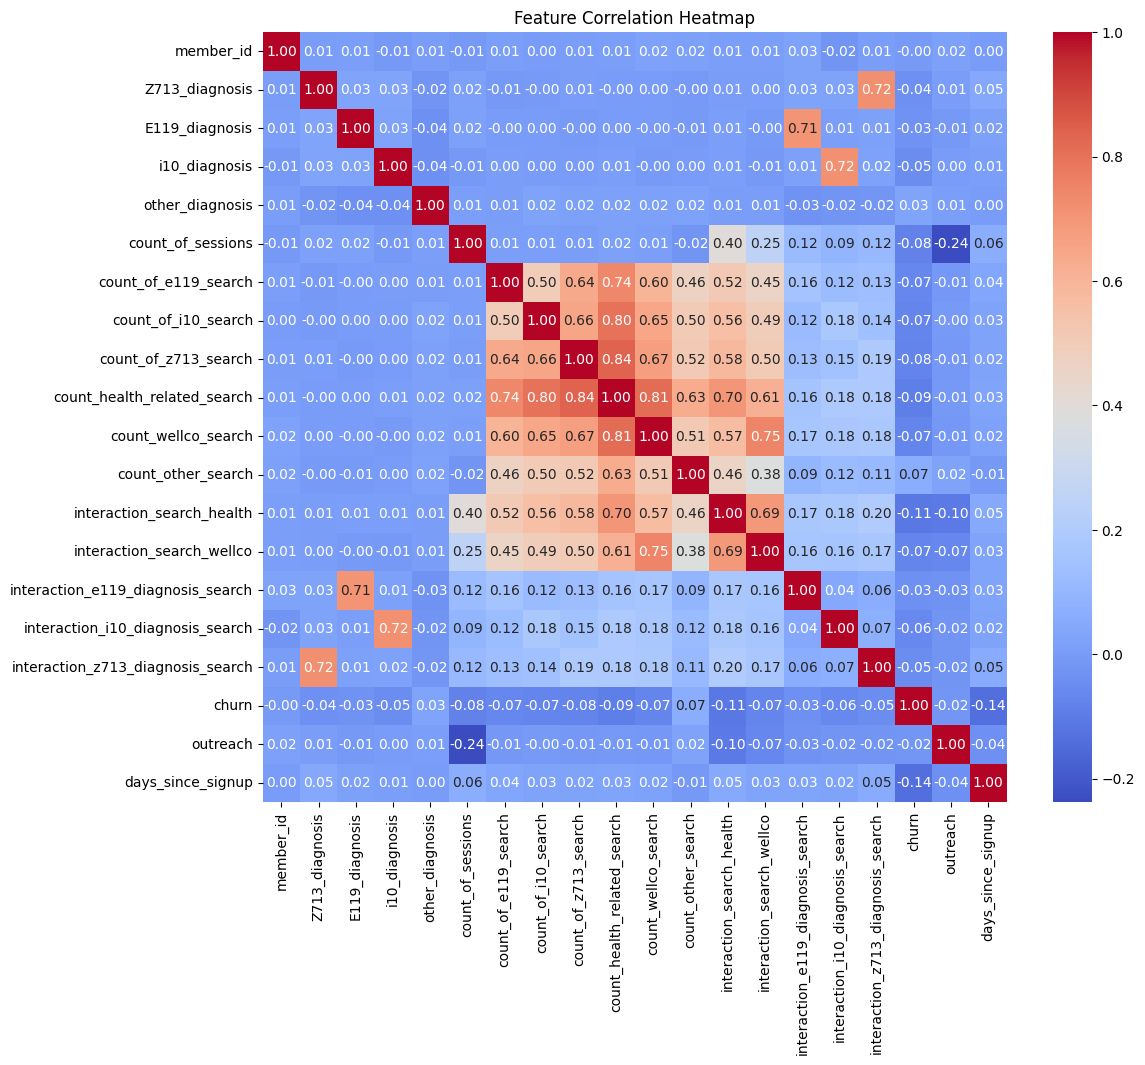

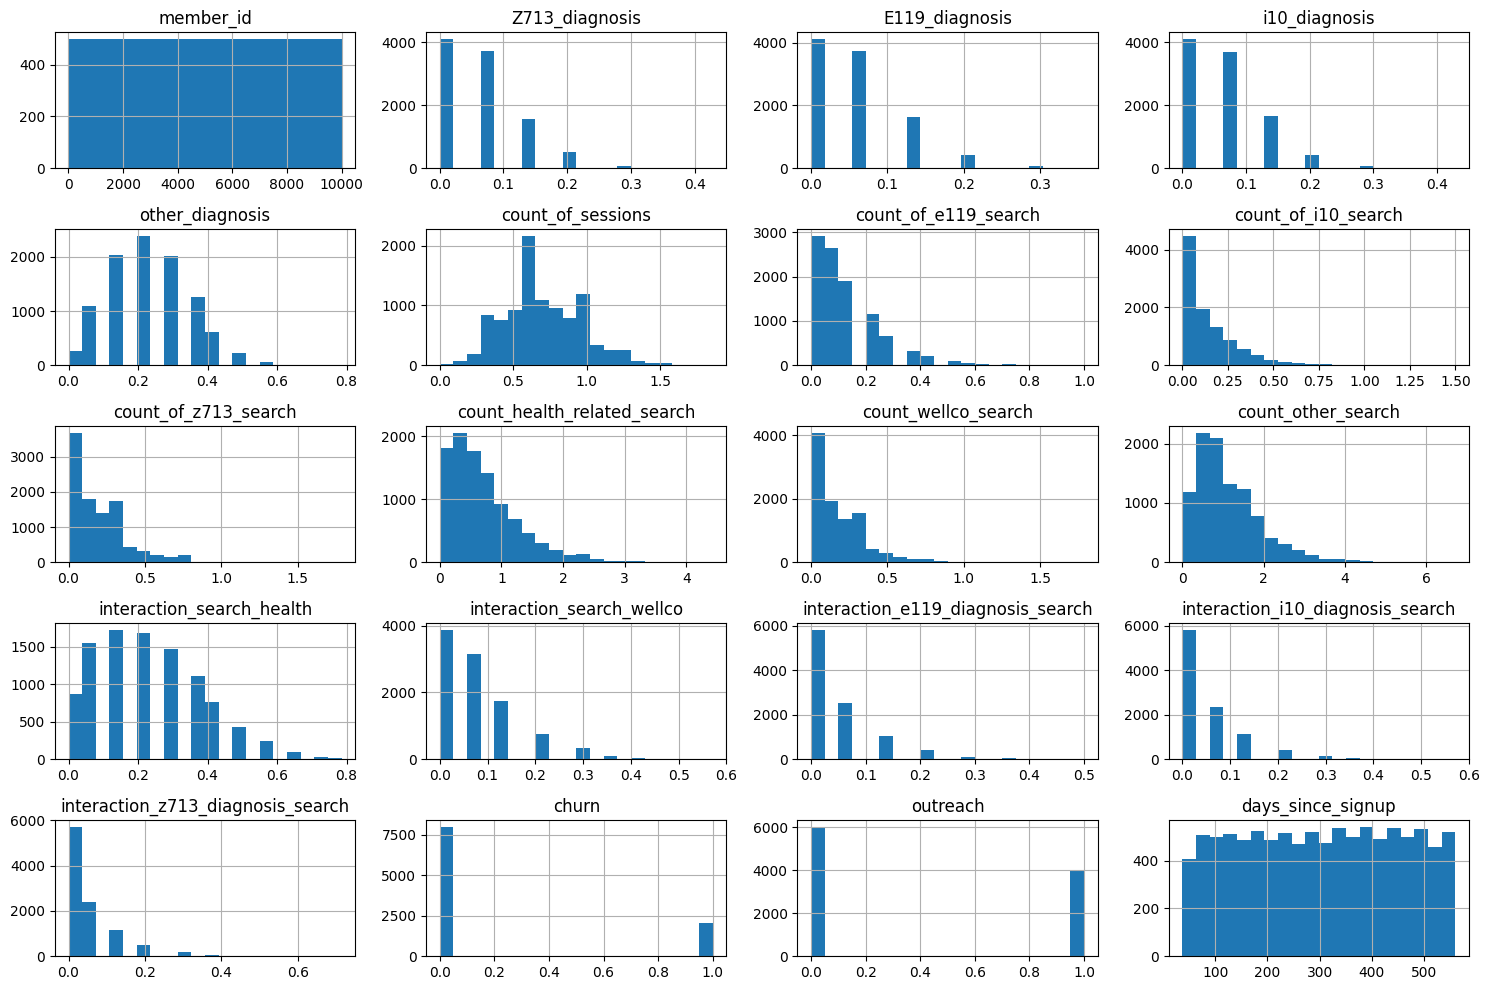

In [43]:
# Create a heatmap of feature correlations
plt.figure(figsize=(12 , 10))
sns.heatmap(member_df.corr(), cmap='coolwarm', annot=True, fmt=".2f")
plt.title('Feature Correlation Heatmap')
plt.show()

# Plot histograms for each feature
member_df.hist(figsize=(15, 10), bins=20)
plt.tight_layout()
plt.show()

## Auto encoder method validation

In [42]:
# Split data into train val test
member_df.dropna(inplace=True)

test_percentile = member_df['days_since_signup'].quantile(0.1)
val_percentile = member_df['days_since_signup'].quantile(0.2) # 10% test + 10% validation

test_df = member_df[member_df['days_since_signup'] <= test_percentile]
val_df = member_df[(member_df['days_since_signup'] > test_percentile) & (member_df['days_since_signup'] <= val_percentile)]
train_df = member_df[member_df['days_since_signup'] > val_percentile]

print(f"Train set shape: {train_df.shape}")
print(f"Validation set shape: {val_df.shape}")
print(f"Test set shape: {test_df.shape}")

Train set shape: (7995, 20)
Validation set shape: (998, 20)
Test set shape: (1005, 20)


In [43]:
# prep data for training AE

features = [c for c in train_df.columns if c not in ["member_id", "churn"]]

X = train_df[features].values
y = train_df["churn"].values
member_ids = train_df["member_id"].values

X_churn = X[y == 1]
X_nonchurn = X[y == 0]
ids_churn = member_ids[y == 1]
ids_nonchurn = member_ids[y == 0]

# Split churned data and their IDs
X_churn_train, X_churn_val, ids_churn_train, ids_churn_val = train_test_split(X_churn, ids_churn, test_size=0.2, random_state=42)

print("Churned users:", X_churn.shape[0])
print("Non-churned users:", X_nonchurn.shape[0])

Churned users: 1421
Non-churned users: 6574


In [49]:
# Build Autoencoder
input_dim = X.shape[1]
latent_dim = 4

input_layer = layers.Input(shape=(input_dim,))


# Encoder
encoded = layers.Dense(12, activation="relu")(input_layer)
encoded = layers.Dropout(0.01)(encoded)
encoded = layers.Dense(latent_dim, activation="relu")(encoded)

# Decoder
decoded = layers.Dense(12, activation="relu")(encoded)
decoded = layers.Dropout(0.01)(decoded)
decoded = layers.Dense(input_dim, activation="linear")(decoded)

# Model
autoencoder = models.Model(inputs=input_layer, outputs=decoded)

autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss="mse")


autoencoder.summary()


Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 18)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 12)             │           228 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 12)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 4)              │            52 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 12)             │            60 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 12)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 18)             │           234 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 574 (2.24 KB)

 Trainable params: 574 (2.24 KB)

 Non-trainable params: 0 (0.00 B)

In [45]:
# Train on churned users only
model_ae_churned = autoencoder.fit(
    X_churn_train, X_churn_train,
    epochs=100,
    batch_size=32,
    shuffle=False,
    validation_data=(X_churn_val, X_churn_val),
    verbose=1
)


Epoch 1/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 6952.7827 - val_loss: 6569.6660
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6818.9019 - val_loss: 6460.3438
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6712.4414 - val_loss: 6369.9072
Epoch 4/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6614.9785 - val_loss: 6294.4478
Epoch 5/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6546.0044 - val_loss: 6230.3003
Epoch 6/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6477.3125 - val_loss: 6171.8271
Epoch 7/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6420.8013 - val_loss: 6115.0952
Epoch 8/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6355.8872 - val_loss: 6055.0635
Epoch 9/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6294.2329 - val_loss: 5990.5254
Epoch 10/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6225.8140 - val_loss: 5921.2065
Epoch 11/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6150.2246 - val_loss: 5847.15

In [47]:
# Calculate reconstruction errors for the churned training data
reconstructions_churn_train = autoencoder.predict(X_churn_train)
mse_churn_train = np.mean(np.square(X_churn_train - reconstructions_churn_train), axis=1)

# Create a temporary dataframe to hold member IDs and errors
churn_train_errors = pd.DataFrame({
    "member_id": ids_churn_train,
    "recon_error": mse_churn_train
})

# Calculate the threshold for the top 10% highest errors
error_threshold = churn_train_errors['recon_error'].quantile(0.8)

# Identify member IDs to remove (those with error > threshold)
members_to_remove = churn_train_errors[churn_train_errors['recon_error'] > error_threshold]['member_id']

# Filter the training data to remove these members
train_df_filtered = train_df[~train_df['member_id'].isin(members_to_remove)]

# Update X_churn_train and ids_churn_train based on the filtered dataframe
X_churn_train = train_df_filtered[train_df_filtered['churn'] == 1][features].values
ids_churn_train = train_df_filtered[train_df_filtered['churn'] == 1]["member_id"].values
X_nonchurn_train = train_df_filtered[train_df_filtered['churn'] == 0][features].values
ids_nonchurn_train = train_df_filtered[train_df_filtered['churn'] == 0]["member_id"].values


print(f"Original churned training users: {len(ids_churn_train) + len(members_to_remove)}")
print(f"Filtered churned training users: {len(ids_churn_train)}")
print(f"Number of users removed: {len(members_to_remove)}")

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Original churned training users: 1421
Filtered churned training users: 1194
Number of users removed: 227


In [50]:
# Train on churned users only after filtering the outlier churned users
new_ae_churned_without_outliers = autoencoder.fit(
    X_churn_train, X_churn_train,
    epochs=85,
    batch_size=32,
    shuffle=False,
    validation_data=(X_churn_val, X_churn_val),
    verbose=1
)

Epoch 1/85
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 5885.9048 - val_loss: 6771.1479
Epoch 2/85
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5775.1812 - val_loss: 6661.7393
Epoch 3/85
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5687.6675 - val_loss: 6569.9971
Epoch 4/85
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5609.0420 - val_loss: 6491.5571
Epoch 5/85
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5543.0332 - val_loss: 6423.3535
Epoch 6/85
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5485.6606 - val_loss: 6361.7891
Epoch 7/85
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5430.7051 - val_loss: 6304.8042
Epoch 8/85
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5383.8838 - val_loss: 6249.7534
Epoch 9/85
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5341.4907 - val_loss: 6194.8047
Epoch 10/85
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5291.8286 - val_loss: 6138.0942
Epoch 11/85
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5245.0928 - val_loss: 6077.3525
Epoch 12

In [51]:
# Select features for validation data (excluding member_id and churn)
features = [c for c in val_df.columns if c not in ["member_id", "churn"]]
X_val = val_df[features].values

# Predict on validation data and compute reconstruction error
reconstructions_val = autoencoder.predict(X_val)
mse_val = np.mean(np.square(X_val - reconstructions_val), axis=1)

# Add reconstruction errors to val_df
val_df['recon_error'] = mse_val

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/tmp/ipython-input-1275515083.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df['recon_error'] = mse_val


### Choose threshold

In [52]:
def ks_threshold(y_true, recon_error):
    """
    Compute KS-based threshold for reconstruction error.

    Parameters
    ----------
    y_true : array-like
        Binary labels (1 = churn, 0 = non-churn).
    recon_error : array-like
        Reconstruction error per sample (e.g., MSE).

    Returns
    -------
    threshold : float
        Optimal threshold on reconstruction error (KS cutoff).
    ks_stat : float
        KS statistic value at the threshold.
    """
    # put into dataframe for sorting
    df = pd.DataFrame({"y": y_true, "err": recon_error})
    df = df.sort_values("err")

    # cumulative distributions
    cum_churn = np.cumsum(df["y"]) / df["y"].sum()
    cum_nonchurn = np.cumsum(1 - df["y"]) / (1 - df["y"]).sum()

    # KS statistic
    ks_values = np.abs(cum_churn - cum_nonchurn)
    ks_stat = ks_values.max()
    ks_idx = ks_values.idxmax()

    # threshold is the error value at max KS
    threshold = df.iloc[ks_idx]["err"]

    return threshold, ks_stat

In [53]:
labels = val_df['churn'].tolist()
recon_error = val_df['recon_error'].tolist()
th, ks = ks_threshold(labels, recon_error)
print("Threshold:", th, "KS:", ks)


Threshold: 0.09889923877625055 KS: 0.07344333187469435


### Test results

In [54]:
features = [c for c in test_df.columns if c not in ["member_id", "churn"]]
X_test = test_df[features].values

reconstructions_test = autoencoder.predict(X_test)
mse_test = np.mean(np.square(X_test - reconstructions_test), axis=1)

test_df['recon_error'] = mse_test

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/tmp/ipython-input-1097288262.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['recon_error'] = mse_test


In [55]:
test_df['pred'] = (test_df['recon_error'] < th).astype(int)


/tmp/ipython-input-303014502.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['pred'] = (test_df['recon_error'] < th).astype(int)


In [56]:
# Get the true labels and predictions from the test set
y_true = test_df['churn']
y_pred = test_df['pred']

# Produce classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_true, y_pred)
print(f"ROC AUC Score: {roc_auc:.4f}")

Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.71      0.69       671
           1       0.35      0.32      0.33       334

    accuracy                           0.58      1005
   macro avg       0.51      0.51      0.51      1005
weighted avg       0.57      0.58      0.57      1005

ROC AUC Score: 0.5141


## Autoencoder builder

### Train on all the churned users

In [17]:
member_df.dropna(inplace=True)
churned_users = member_df[member_df['churn'] == 1]
nonchurned_users = member_df[member_df['churn'] == 0]

In [23]:
# prep data for training AE

features = [c for c in churned_users.columns if c not in ["member_id", "churn"]]

X = churned_users[features].values
churned_ids = churned_users["member_id"].values

In [26]:
# Build Autoencoder
input_dim = X.shape[1]
latent_dim = 4

input_layer = layers.Input(shape=(input_dim,))


# Encoder
encoded = layers.Dense(12, activation="relu")(input_layer)
encoded = layers.Dropout(0.01)(encoded)
encoded = layers.Dense(latent_dim, activation="relu")(encoded)

# Decoder
decoded = layers.Dense(12, activation="relu")(encoded)
decoded = layers.Dropout(0.01)(decoded)
decoded = layers.Dense(input_dim, activation="linear")(decoded)

# Model
autoencoder = models.Model(inputs=input_layer, outputs=decoded)

autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss="mse")


autoencoder.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 18)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 12)             │           228 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 12)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 4)              │            52 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 12)             │            60 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 12)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 18)             │           234 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 574 (2.24 KB)

 Trainable params: 574 (2.24 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Train on churned users only
model_ae_churned = autoencoder.fit(
    X, X,
    epochs=100,
    batch_size=32,
    shuffle=False,
    verbose=1
)


Epoch 1/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 4955.2070
Epoch 2/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4907.9858
Epoch 3/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4862.6348
Epoch 4/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4802.2700
Epoch 5/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4738.3359
Epoch 6/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4644.0317
Epoch 7/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4538.4282
Epoch 8/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4412.1343
Epoch 9/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4267.7676
Epoch 10/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4107.4565
Epoch 11/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3917.5542
Epoch 12/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3708.0332
Epoch 13/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3483.5613
Epoch 14/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3241.1489
Epoch 15/100
64/64 ━━━━━━━━━━

### Filter outlier churn users

In [24]:
# Calculate reconstruction errors for the churned training data
reconstructions_churn = autoencoder.predict(X)
mse_churn_train = np.mean(np.square(X - reconstructions_churn), axis=1)
# Create a temporary dataframe to hold member IDs and errors
churn_errors = pd.DataFrame({
    "member_id": churned_ids,
    "recon_error": mse_churn_train
})

# Calculate the threshold for the top 10% highest errors
error_threshold = churn_errors['recon_error'].quantile(0.8)

# Identify member IDs to remove (those with error > threshold)
members_to_remove = churn_errors[churn_errors['recon_error'] > error_threshold]['member_id']

# Filter the training data to remove these members
churn_filtered = churned_users[~churned_users['member_id'].isin(members_to_remove)]

# Update X_churn_train and ids_churn_train based on the filtered dataframe
X = churn_filtered[features].values
churned_ids = churn_filtered["member_id"].values


print(f"Original churned training users: {len(churned_ids) + len(members_to_remove)}")
print(f"Filtered churned training users: {len(churned_ids)}")
print(f"Number of users removed: {len(members_to_remove)}")

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Original churned training users: 2020
Filtered churned training users: 1616
Number of users removed: 404


In [27]:
# Train on churned users only after filtering the outlier churned users
new_ae_churned_without_outliers = autoencoder.fit(
    X, X,
    epochs=85,
    batch_size=32,
    shuffle=False,
    verbose=1
)

Epoch 1/85
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 2692.5093
Epoch 2/85
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2652.9104
Epoch 3/85
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2612.3970
Epoch 4/85
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2561.8147
Epoch 5/85
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2510.4116
Epoch 6/85
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2434.1223
Epoch 7/85
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2358.8430
Epoch 8/85
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2282.1423
Epoch 9/85
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2191.2959
Epoch 10/85
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2108.9824
Epoch 11/85
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1999.9154
Epoch 12/85
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1904.8788
Epoch 13/85
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1799.1248
Epoch 14/85
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1680.9579
Epoch 15/85
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3

### Predict on non-churned users

In [29]:
th = 0.09889923877625055

In [30]:
features = [c for c in nonchurned_users.columns if c not in ["member_id", "churn"]]
X_non_churn = nonchurned_users[features].values

reconstructions_test = autoencoder.predict(X_non_churn)
mse_test = np.mean(np.square(X_non_churn - reconstructions_test), axis=1)

nonchurned_users['recon_error'] = mse_test

nonchurned_users['pred'] = (nonchurned_users['recon_error'] < th).astype(int)


250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/tmp/ipython-input-4248843836.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nonchurned_users['recon_error'] = mse_test
/tmp/ipython-input-4248843836.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nonchurned_users['pred'] = (nonchurned_users['recon_error'] < th).astype(int)


In [32]:
high_risk_churn_users = nonchurned_users.loc[nonchurned_users['pred'] == 1]
print(f"Number of high risk churn users: {len(high_risk_churn_users)}")

Number of high risk churn users: 670


In [35]:
high_risk_churn_users_ranks = high_risk_churn_users[['member_id','recon_error']].sort_values(by='recon_error', ascending=True).reset_index()
high_risk_churn_users_ranks['rank'] = high_risk_churn_users_ranks.index + 1
high_risk_churn_users_ranks.head()

,index,member_id,recon_error,rank
0,122,123,0.013422,1
1,8451,8452,0.015014,2
2,6575,6576,0.015460,3
3,7471,7472,0.015793,4
4,1235,1236,0.017946,5


In [36]:
path_to_save = "/content/drive/MyDrive/cv and more/home_tasks_25/vi/data/high_risk_churn_users.csv"
high_risk_churn_users_ranks.to_csv(path_to_save, index=False)
print(f"high_risk_churn_users_ranks saved to {path_to_save}")

high_risk_churn_users_ranks saved to /content/drive/MyDrive/cv and more/home_tasks_25/vi/data/high_risk_churn_users.csv
